In [1]:
import pandas as pd
import os
import sys
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from io import StringIO

"""Search list of str for first occurence of a substring and return index of that str"""
def find_snippet(lines, snippet):
    indices, i = [], 0
    while i < len(lines): #iterate over all str in list
        if lines[i].find(snippet) > -1: indices.append(i) #str.find returns -1 if substring not in str, thus all results >-1 contain substring somewhere
        i += 1
    return indices[0] #return only the first occurence

"""Calculate activity in umol/h/g from ppm and flow rate"""
def calculate_activity(ppm):
    global catalyst_amount
    global flow_rate #in nccm (normal cubic centimeters per minute)
    normal_density = 44.616 #in moles/m3 or umol/mL
    umoles_per_h = flow_rate * 60 * normal_density
    activity = umoles_per_h * (ppm/1000000) / (catalyst_amount/1000)
    return activity

"""Open file and extract all neccessary data"""
def extract_data_from_file(file, filter_sample):
    global experiment
    with open(file,'r') as text_file: text_file = open(file, "r")
    report = text_file.read()
    lines = report.split("\n") #create list of str, where each is a line of the txt file
    
    data = {}
    for snippet in ["Acquired", "Sample Name", "Sample ID", "Detector Name"]: #extract parameters and save in dict
        line = lines[find_snippet(lines, snippet)]
        data[snippet] = line.split("\t")[-1]
    if data["Detector Name"] == "TCD1": return #check if measured by TCD or BID; return empty if TCD
    else: del data["Detector Name"] #drop now unnecessary entry from dict and continue if BID
    if filter_sample and data["Sample Name"].find(experiment) < 0: return #filter out all samples from batch that are from a different experiment
        
    results_table = lines[find_snippet(lines, "[Compound Results(Ch1)]"):] #truncate file to last few lines containing BID data
    first_line = find_snippet(results_table,"# of IDs")+1
    results_table = results_table[first_line:] #truncate to table only
    results_table_new = ""
    for line in results_table: #reformat each line to be CSV-like
        line = line.replace(",",".")
        line = line.replace("\t", ";")
        if line != "": results_table_new += line+"\n" #add non-empty lines to new str
    results_table = results_table_new
    df = pd.read_csv(StringIO(results_table), sep=";")
    df = df[['Name', 'Conc.']] #read str into df and drop unnecessary columns
    for row in range(len(df)):
        data[df.iat[row,0]+" (ppm)"] = df.iat[row,1] #add entries to dictionary where Name is key and Conc. is value
        data[df.iat[row,0]+" (umol/h/g)"] = calculate_activity(df.iat[row,1]) #convert concentration to umol/h/g 
    
    return pd.DataFrame(data, index=[0]) #return as dataframe


"""Apply a correction factor to H2 and CO cencentrations in ppm"""
def apply_correction(experiment_data):
    #duplicate data first then recalculate each value
    experiment_data['H2 (ppm) uncorr'] = experiment_data['H2 (ppm)'] 
    experiment_data['CO (ppm) uncorr'] = experiment_data['CO (ppm)']
    experiment_data['H2 (ppm)'] = experiment_data['H2 (ppm) uncorr'] * H2_correction_factor
    experiment_data['CO (ppm)'] = experiment_data['CO (ppm) uncorr'] * CO_correction_factor
    return experiment_data

"""Create and roughly format a figure"""
def create_figure(colors,linewidth,ticklength):
    sns.set_theme(style="ticks", font_scale=1.25)
    sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
    pal = sns.set_palette(sns.color_palette(colors))

    fig = plt.figure(figsize=(4.5,4.7), dpi= 150)
        
    plt.tick_params('both', length=ticklength, width=linewidth, which='major')
    plt.tick_params('both', length=ticklength/2, width=linewidth, which='minor')
    ax = fig.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(linewidth)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.xaxis.set_zorder(2)
    ax.yaxis.set_zorder(2)
    return fig, pal, ax

"""Read in experiment's metadata from csv file"""
def read_metadata(experiment):
    metadata = pd.read_csv ('./experiment_metadata.csv', header=0, index_col='experiment')
    exp_key = int(experiment[4:])
    return metadata.at[exp_key,'title'], metadata.at[exp_key,'catalyst_amount'], metadata.at[exp_key,'re_mass_pct'], metadata.at[exp_key,'flow_rate'], metadata.at[exp_key,'H2_correction_factor'], metadata.at[exp_key,'CO_correction_factor']

"""Read all reports in the specified folder, extract data and save in table"""
def read_folder(experiment, catalyst_amount, re_mass_perc, flow_rate, filter_sample, view):
    #create file list
    location = "./"+experiment+"/"
    filenames = []
    for file in sorted(glob.glob(location+"*.txt")): filenames.append(file) 
    savename = location+"summary.csv"
    print(filenames)
    
    #read in all files and collect in a single dataframe
    experiment_data = pd.DataFrame()
    for file in filenames:
        data = pd.DataFrame() #create empty df first, then concatonate, thus len(data) returns either 0 or 1, otherwise error
        data = pd.concat([data,extract_data_from_file(file,filter_sample)],ignore_index=True)
        if len(data) == 1: #only include non-empty data created from files measured by BID
            experiment_data = pd.concat([experiment_data, data],ignore_index=True) #combine all results into one df
    #experiment_data = experiment_data.set_index('Sample ID') #reassign index to Sample ID

    #calculate time since experiment start for each measurement and add to dataframe
    aquired, time = pd.to_datetime(experiment_data['Acquired'],format= '%d.%m.%Y %H:%M:%S'), []
    for i in range(0,len(aquired)): 
        delta = aquired[i] - aquired[0]
        time.append(int(pd.Timedelta(delta, unit='minutes').total_seconds()/60))
    experiment_data.insert(1, 'Time (min)', time)

    experiment_data = apply_correction(experiment_data)
    
    #calculate total amount produced
    H2_produced,CO_produced, selectivity = [0],[0],[0]
    for i in experiment_data.index[0:-1]:
        time_in_h = (experiment_data['Time (min)'][i+1] - experiment_data['Time (min)'][i])/60
        activity_H2 = (experiment_data['H2 (umol/h/g)'][i+1] + experiment_data['H2 (umol/h/g)'][i])/2
        activity_CO = (experiment_data['CO (umol/h/g)'][i+1] + experiment_data['CO (umol/h/g)'][i])/2
        selectivity.append(activity_CO / activity_H2)
        H2_produced.append(H2_produced[i] + activity_H2 * time_in_h)
        CO_produced.append(CO_produced[i] + activity_CO * time_in_h)
    experiment_data['H2 (umol/g)'] = H2_produced
    experiment_data['CO (umol/g)'] = CO_produced
    experiment_data['Selectivity'] = selectivity
        
    #calculate TON
    H2_TON, CO_TON = [0],[0]
    H2_umol_act, CO_umol_act = [0],[0]
    H2_umol, CO_umol = [0],[0]
    for i in experiment_data.index[0:-1]:
        try:
            H2_TON.append(H2_produced[i]/1000000 / re_mass_pct*100 *186.21)
            CO_TON.append(CO_produced[i]/1000000 / re_mass_pct*100 *186.21)
        except: pass
        H2_umol_act.append(experiment_data['H2 (umol/h/g)'][i] * catalyst_amount/1000)
        CO_umol_act.append(experiment_data['CO (umol/h/g)'][i] * catalyst_amount/1000)
        H2_umol.append(experiment_data['H2 (umol/g)'][i] * 5/1000)
        CO_umol.append(experiment_data['CO (umol/g)'][i] * 5/1000)
    try:
        experiment_data['H2 TON'] = H2_TON
        experiment_data['CO TON'] = CO_TON
    except: pass
    experiment_data['H2 (umol/h)'] = H2_umol_act
    experiment_data['CO (umol/h)'] = CO_umol_act
    experiment_data['H2 (umol)'] = H2_umol
    experiment_data['CO (umol)'] = CO_umol

    #either save data where all but data from sample equal to folder name were excluded or split results into samples and save individually
    if filter_sample:
        experiment_data.drop('Sample ID',axis='columns', inplace=True)
        experiment_data.to_csv(savename, index=False)
        print(experiment_data)
        return(experiment_data)
    else:
        sample_data = [y for x, y in experiment_data.groupby('Sample ID', as_index=False)]
        for i, df in enumerate(sample_data): 
            sample_id = df['Sample ID'].to_list()[0]
            df.drop('Sample ID',axis='columns', inplace=True)
            df.to_csv(savename[:-4]+"_ID_"+str(sample_id)+".csv", index=False)
            print(df)
            print("\n")
        return(sample_data)

"""Plot data in a figure and save"""
def plot_data(df, experiment, title, view):
    if title.find("TAPT") > -1 or title.find("T COF") > -1: colors = ['#91354B','#DEB2BC','#5C2230','#C8697F'] #['#C8697F','#5C2230','#DEB2BC','#91354B']
    elif title.find("PTTA") > -1 or title.find("P COF") > -1: colors = ['#35700C','#A8D18D','#204307','#669744'] #['#669744','#204307','#A8D18D','#35700C']
    elif title.find("TAPB") > -1 or title.find("B COF") > -1: colors = ['#15397A','#8EA5B8','#09214D','#5C6F92'] #['#5C6F92','#09214D','#8EA5B8','#15397A']
    else: colors = ['#747575','#CFCFCF','#505050','#A3A4A4'] #['#A3A4A4','#505050','#CFCFCF','#747575']
    first_co2 = find_snippet(df['Sample Name'].to_list(),"CO2")
    linewidth = 1.5
    ticklength = 7
    
    if type(df) is list: print("Multiple samples read in. Use sample filter to create figure.")
    else:
        fig, pal, ax = create_figure(colors,linewidth,ticklength)

        #plt.axvspan(df['Time (min)'].iloc[0],(df['Time (min)'].iloc[0]+df['Time (min)'].iloc[1])/2,ymax=0.5, facecolor='black', alpha=0.10, zorder=0)
        #plt.axvspan((df['Time (min)'].iloc[0]+df['Time (min)'].iloc[1])/2,(df['Time (min)'][first_co2-1]+df['Time (min)'][first_co2])/2,ymax=0.5, facecolor='black', alpha=0.05, zorder=0)
        if label_CO2: plt.axvline((df['Time (min)'][first_co2-1]+df['Time (min)'][first_co2])/2, ymin=0.05, ymax=0.65, color='k', linestyle='dashed')
        
        plt.plot('Time (min)', 'H2 (umol/h/g)', data=df, color=colors[2], linestyle='-', marker='o', markersize=7, markeredgecolor='w', label='Activity H$_2$', zorder=2)
        plt.plot('Time (min)', 'CO (umol/h/g)', data=df, color=colors[3], linestyle='-', marker='o', markersize=7, markeredgecolor='w', label='Activity CO', zorder=2)
        ax.set_ylabel(r"Activity / μmol $\mathdefault{h^{-1} g^{-1}}$", fontsize='14', fontweight='bold')
        plt.xlabel(r"Time / min", fontsize='14', fontweight='bold')
        ax.patch.set_alpha(0)
        
        ax2 = ax.twinx()
        if view=="TON" and re_mass_pct>0:
            plt.stackplot(df['Time (min)'],[df['H2 TON'],df['CO TON']], labels=['TON H$_2$','TON CO'], colors=pal, zorder=0)
            ax2.set_ylabel(r"Combined TON", fontsize='14', fontweight='bold')
        elif view=="TON":
            plt.stackplot(df['Time (min)'],[df['H2 (umol)'],df['CO (umol)']], labels=['Amount H$_2$','Amount CO'], colors=pal, zorder=0)
            ax2.set_ylabel(r"Combined amount / μmol", fontsize='14', fontweight='bold')
        elif view=="total_amount":
            plt.stackplot(df['Time (min)'],[df['H2 (umol/g)'],df['CO (umol/g)']], labels=['Amount H$_2$','Amount CO'], colors=pal, zorder=0)
            ax2.set_ylabel(r"Combined amount / μmol $\mathdefault{g^{-1}}$", fontsize='14', fontweight='bold')
        else: ax2.set_ylabel(r"Activity / μmol $\mathdefault{h^{-1}}$", fontsize='14', fontweight='bold')
        ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax2.set_zorder(-1)

        ax.set_xlim(df['Time (min)'][0],df['Time (min)'].iloc[-1])
#        ax.set_xlim([0,  279]) ################
        plt.tick_params('both', length=ticklength, width=linewidth, which='major')
        plt.tick_params('both', length=ticklength/2, width=linewidth, which='minor')
        
        if legend:
            plt.title(title, loc='left', style='italic', x=0.04, y=0.87)#, pad=-16)
            ax.legend(loc='upper left', title=None, fontsize=12, frameon=False, bbox_to_anchor=[0, 0.875])
            if view=="TON": ax2.legend(loc='upper left', title=None, fontsize=12, frameon=False, bbox_to_anchor=[0.5, 0.875])
        
            def set_ymargin(ax, top, bottom): #from https://stackoverflow.com/questions/49382105/matplotlib-set-different-margins-for-left-and-right-side
                ax.set_ymargin(0)
                ax.autoscale_view()
                lim = ax.get_ylim()
                delta = np.diff(lim)
                bottom = lim[0] - delta*bottom
                top = lim[1] + delta*top
                ax.set_ylim(bottom,top)
            set_ymargin(ax, 0.5, 0)
            if view == "TON": set_ymargin(ax2, 0.5, 0)
        
        if view == "TON": 
            plt.savefig("./Figures TON/"+experiment+"_TON.svg",bbox_inches='tight',transparent=True)
            plt.savefig("./Figures TON/"+experiment+"_TON.png",bbox_inches='tight',transparent=True)
        else: 
            plt.savefig("./Figures/"+experiment+".svg",bbox_inches='tight',transparent=True)
            plt.savefig("./Figures/"+experiment+".png",bbox_inches='tight',transparent=True)

['./PUZ-493/Alex_20102022_PUZ493_.txt', './PUZ-493/Alex_20102022_PUZ493_001.txt', './PUZ-493/Alex_20102022_PUZ493_002.txt', './PUZ-493/Alex_20102022_PUZ493_003.txt', './PUZ-493/Alex_20102022_PUZ493_004.txt', './PUZ-493/Alex_20102022_PUZ493_005.txt', './PUZ-493/Alex_20102022_PUZ493_006.txt', './PUZ-493/Alex_20102022_PUZ493_007.txt', './PUZ-493/Alex_20102022_PUZ493_008.txt', './PUZ-493/Alex_20102022_PUZ493_009.txt', './PUZ-493/Alex_20102022_PUZ493_010.txt', './PUZ-493/Alex_20102022_PUZ493_011.txt', './PUZ-493/Alex_20102022_PUZ493_012.txt', './PUZ-493/Alex_20102022_PUZ493_013.txt', './PUZ-493/Alex_20102022_PUZ493_014.txt', './PUZ-493/Alex_20102022_PUZ493_015.txt', './PUZ-493/Alex_20102022_PUZ493_016.txt', './PUZ-493/Alex_20102022_PUZ493_017.txt', './PUZ-493/Alex_20102022_PUZ493_018.txt', './PUZ-493/Alex_20102022_PUZ493_019.txt']
              Acquired  Time (min)                              Sample Name  \
0  20.10.2022 12:08:08           0   PUZ-493_5ReTAPT_46ACN_04TEOA_5CO2_dark   
1  2

/tmp/ipykernel_7714/791499036.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  selectivity.append(activity_CO / activity_H2)


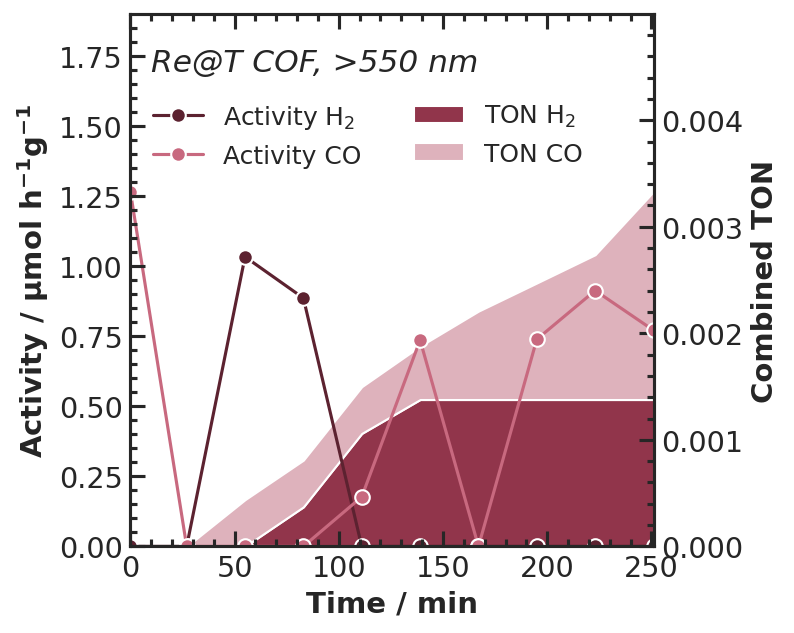

In [2]:
view = "TON" # set to either "TON" or "total_amount"
legend = True
filter_sample = True
label_CO2 = False

experiment = "PUZ-493" #single experiment
title, catalyst_amount, re_mass_pct, flow_rate, H2_correction_factor, CO_correction_factor = read_metadata(experiment)
data = read_folder(experiment, catalyst_amount, re_mass_pct, flow_rate, filter_sample, view)
plot_data(data, experiment, title, view)